In [2]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, MakeScaffoldGeneric, GetScaffoldForMol
from typing import List, Tuple
from collections import defaultdict, Counter

In [13]:
import pandas as pd
import os
import pickle
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from conf_ensemble import ConfEnsembleLibrary
from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ccdc_rdkit_connector import CcdcRdkitConnector

In [14]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [15]:
data_dir_path = 'data/'

# Extract PDBBind conformations

In [16]:
pdbbind_refined_dir_path = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir_path = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [17]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(os.path.join(pdbbind_refined_dir_path, 'index', 'INDEX_general_PL_data.2020'), widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [18]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG)
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX)
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3)
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP)
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM)


In [19]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [20]:
pl_data.shape

(16844, 7)

In [21]:
correct_pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [22]:
def extract_pdbbind_mols(directory_path, query_pdb_ids) :
    mols = []
    pdb_ids = [pdb_id for pdb_id in os.listdir(directory_path) if pdb_id in query_pdb_ids]
    for pdb_id in pdb_ids :
        mol2path = os.path.join(directory_path, pdb_id, f'{pdb_id}_ligand.mol2')
        try :
            mol = Chem.rdmolfiles.MolFromMol2File(mol2path)
            if mol is not None :
                rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
                if rdmol is not None : #rdkit parsable
                    #mol = PropertyMol(mol)
                    mol.GetConformer().SetProp('PDB_ID', pdb_id)
                    mols.append(mol)
                else :
                    print('Not RDKit parsable')
        except :
            print('Impossible to read mol2 file for ' + pdb_id)
            
    return mols

In [23]:
general_mols = extract_pdbbind_mols(pdbbind_general_dir_path, correct_pdb_ids)
print(len(general_mols))

RDKit WARNING: [13:51:21] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:21] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:21] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:21] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 2k0g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 1it6_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 4lph_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 6oh3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 3fjz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:21] 6eo0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING

Not RDKit parsable


RDKit WARNING: [13:51:22] 4jit_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 1ml1_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:22] 4li0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:22] 4p45_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 5ogk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 5knr_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 4jit_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 4li0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 4p45_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:22] 2cmc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 2cmc_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:22] 4kby_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:22] 4kby_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RD

Not RDKit parsable


RDKit WARNING: [13:51:23] 1fpi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:23] 1fpi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 2bzz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:23] 2bzz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 3wcg_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 2jg8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 2piz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 4yik_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:23] 2o1c_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:51:23] 3wcg_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:23] 2jg8_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:23] 2piz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:

Not RDKit parsable


RDKit WARNING: [13:51:26] 6aec_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 1akv_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:26] 6aec_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:26] 1akv_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 1iig_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 5jbi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:26] 1iig_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:26] 5jbi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 3kr5_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:26] 3kr5_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 5vjn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:26] 3c14_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKi

Not RDKit parsable


RDKit WARNING: [13:51:27] 6hys_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:27] 4jbs_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:27] 2z4z_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 6hys_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:27] 2e9d_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 4jbs_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 2z4z_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 2e9d_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:27] 3e9i_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 3e9i_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:27] 5agt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 5agt_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:27] 1yhm_ligand: warning - O.co2 with non C.2 or S.

10635


RDKit WARNING: [13:51:28] 1c8v_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 1c8v_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 6a03_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 6a03_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 1q6t_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 1q6t_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 2pu0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 1a50_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 2pu0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 1w1d_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [13:51:28] 6n94_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 1a50_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[13:51:28] 1w1d_ligand: warning - O.co2 wit

In [24]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list_test.p'), 'wb') as f :
    pickle.dump(general_mols, f)

In [25]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list_test.p'), 'rb') as f :
    general_mols = pickle.load(f)

RuntimeError: invalid value in pickle

In [35]:
for i in tqdm(range(len(general_mols))) :
    mols = general_mols[i]
    with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list_test.p'), 'wb') as f :
        pickle.dump(mols, f)
    try :
        with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list_test.p'), 'rb') as f :
            pickle.load(f)
    except :
        print(f'mol {i} is the issue')

 51%|██████████████████▎                 | 5403/10635 [00:01<00:01, 4463.23it/s]

mol 4865 is the issue


100%|███████████████████████████████████| 10635/10635 [00:02<00:00, 4436.62it/s]

mol 10050 is the issue


In [45]:
faulty_smiles = [Chem.MolToSmiles(mol) for i, mol in enumerate(general_mols) if i in [4865, 10050]]
faulty_smiles

['O=C[Ru+9]12345(C6=C1C2C3=C64)n1c2ccc(O)cc2c2c3c(c4ccc[n+]5c4c21)C(=O)NC3=O',
 'Cc1cc2c3c(c4c5ccccc5n5c4c2[n+](c1)[Ru+9]51246(Cl)C5=C(C(=O)[O-])C1=C2C4=C56)C(=O)NC3=O']

In [48]:
ru_mols = [mol for i, mol in enumerate(general_mols) if 'Ru' in Chem.MolToSmiles(mol)]

In [52]:
ru_mols[0].GetConformer().GetPropsAsDict()

{'PDB_ID': '3pup'}

In [3]:
random.seed(42)

In [4]:
data_dir_path = 'data/'

In [10]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list.p'), 'rb') as f :
    general_mols = pickle.load(f)

RuntimeError: invalid value in pickle

In [9]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'rb') as f :
    platinum_CEL = pickle.load(f)

RuntimeError: invalid value in pickle

In [5]:
all_mols = general_mols + refined_mols

In [6]:
len(all_mols)

15035

In [7]:
def get_generic_scaffold(mol) :
    try :
        core = GetScaffoldForMol(mol)
        core = MakeScaffoldGeneric(mol=core)
        scaffold = Chem.MolToSmiles(core)
        return scaffold
    except :
        raise Exception('Didnt work')

In [8]:
all_generic_scaffolds = []
correct_smiles = []
for mol in all_mols :
    try :
        scaffold = get_generic_scaffold(mol)
        all_generic_scaffolds.append(scaffold)
        correct_smiles.append(Chem.MolToSmiles(mol))
    except :
        print('Didnt work')

RDKit ERROR: [15:33:08] Explicit valence for atom # 30 C, 5, is greater than permitted
[15:33:08] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 37 C, 6, is greater than permitted
[15:33:08] Explicit valence for atom # 37 C, 6, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 15 C, 5, is greater than permitted
[15:33:08] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 32 C, 6, is greater than permitted
[15:33:08] Explicit valence for atom # 32 C, 6, is greater than permitted


Didnt work
Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:08] Explicit valence for atom # 24 C, 7, is greater than permitted
[15:33:08] Explicit valence for atom # 24 C, 7, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 19 C, 9, is greater than permitted
[15:33:08] Explicit valence for atom # 19 C, 9, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:33:08] Explicit valence for atom # 0 C, 6, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 14 C greater than permitted
[15:33:08] Explicit valence for atom # 14 C greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 32 C, 6, is greater than permitted
[15:33:08] Explicit valence for atom # 32 C, 6, is greater than permitted


Didnt work
Didnt work
Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:08] Explicit valence for atom # 21 C, 9, is greater than permitted
[15:33:08] Explicit valence for atom # 21 C, 9, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 26 C, 5, is greater than permitted
[15:33:08] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [15:33:08] Explicit valence for atom # 49 C, 6, is greater than permitted
[15:33:08] Explicit valence for atom # 49 C, 6, is greater than permitted


Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:09] Explicit valence for atom # 49 C, 6, is greater than permitted
[15:33:09] Explicit valence for atom # 49 C, 6, is greater than permitted


Didnt work


RDKit ERROR: [15:33:09] Explicit valence for atom # 23 C, 7, is greater than permitted
[15:33:09] Explicit valence for atom # 23 C, 7, is greater than permitted
RDKit ERROR: [15:33:10] Explicit valence for atom # 21 C, 9, is greater than permitted
[15:33:10] Explicit valence for atom # 21 C, 9, is greater than permitted
RDKit ERROR: [15:33:10] Explicit valence for atom # 13 C, 5, is greater than permitted
[15:33:10] Explicit valence for atom # 13 C, 5, is greater than permitted


Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:10] Explicit valence for atom # 31 C, 5, is greater than permitted
[15:33:10] Explicit valence for atom # 31 C, 5, is greater than permitted
RDKit ERROR: [15:33:10] Explicit valence for atom # 27 C, 7, is greater than permitted
[15:33:10] Explicit valence for atom # 27 C, 7, is greater than permitted
RDKit ERROR: [15:33:10] Explicit valence for atom # 24 C greater than permitted
[15:33:10] Explicit valence for atom # 24 C greater than permitted
RDKit ERROR: [15:33:10] Explicit valence for atom # 36 C greater than permitted
[15:33:10] Explicit valence for atom # 36 C greater than permitted


Didnt work
Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:11] Explicit valence for atom # 24 C, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 24 C, 6, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 41 C, 9, is greater than permitted
[15:33:11] Explicit valence for atom # 41 C, 9, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 22 C, 7, is greater than permitted
[15:33:11] Explicit valence for atom # 22 C, 7, is greater than permitted


Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:11] Explicit valence for atom # 27 C, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 27 C, 6, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 50 C, 7, is greater than permitted
[15:33:11] Explicit valence for atom # 50 C, 7, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 18 C, 6, is greater than permitted
[15:33:11] Explicit valence for atom # 18 C, 6, is greater than permitted


Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:11] Explicit valence for atom # 21 C, 9, is greater than permitted
[15:33:11] Explicit valence for atom # 21 C, 9, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 22 C, 5, is greater than permitted
[15:33:11] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [15:33:11] Explicit valence for atom # 40 C greater than permitted
[15:33:11] Explicit valence for atom # 40 C greater than permitted


Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:12] Explicit valence for atom # 30 C, 6, is greater than permitted
[15:33:12] Explicit valence for atom # 30 C, 6, is greater than permitted
RDKit ERROR: [15:33:12] Explicit valence for atom # 21 C, 9, is greater than permitted
[15:33:12] Explicit valence for atom # 21 C, 9, is greater than permitted
RDKit ERROR: [15:33:12] Explicit valence for atom # 18 C, 5, is greater than permitted
[15:33:12] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [15:33:12] Explicit valence for atom # 45 C, 6, is greater than permitted
[15:33:12] Explicit valence for atom # 45 C, 6, is greater than permitted


Didnt work
Didnt work
Didnt work
Didnt work


RDKit ERROR: [15:33:12] Explicit valence for atom # 24 C greater than permitted
[15:33:12] Explicit valence for atom # 24 C greater than permitted
RDKit ERROR: [15:33:12] Explicit valence for atom # 26 C, 5, is greater than permitted
[15:33:12] Explicit valence for atom # 26 C, 5, is greater than permitted


Didnt work
Didnt work


RDKit ERROR: [15:33:13] Explicit valence for atom # 21 C, 9, is greater than permitted
[15:33:13] Explicit valence for atom # 21 C, 9, is greater than permitted


Didnt work


RDKit ERROR: [15:33:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[15:33:13] Explicit valence for atom # 0 Cl, 3, is greater than permitted


Didnt work
Didnt work


RDKit ERROR: [15:33:13] Explicit valence for atom # 28 C, 7, is greater than permitted
[15:33:13] Explicit valence for atom # 28 C, 7, is greater than permitted


In [9]:
counter = Counter(all_generic_scaffolds)

In [10]:
print(len(counter))

5243


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


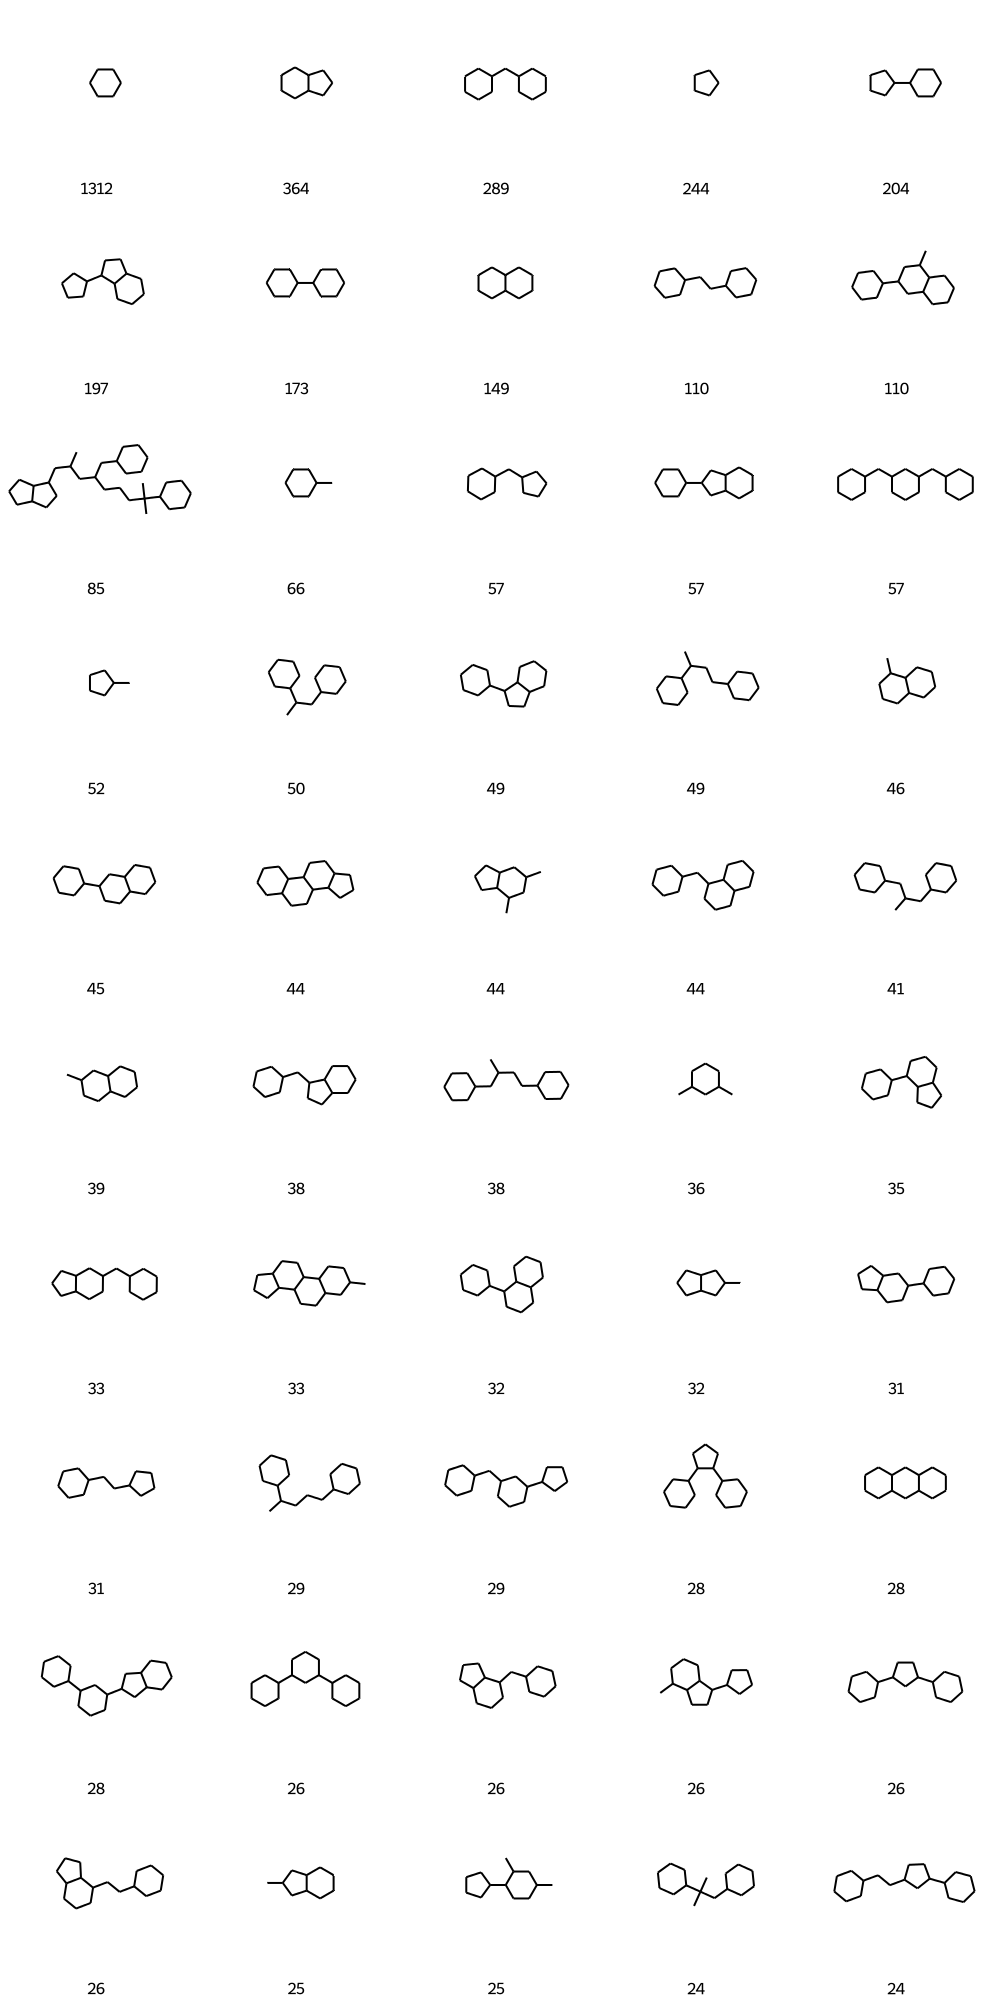

In [11]:
most_counted_scaffold = []
for scaffold, count in counter.most_common() :
    most_counted_scaffold.append(scaffold)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in counter.most_common() if scaffold != ''], 
                          molsPerRow=5,
                         legends=[str(count) for scaffold, count in counter.most_common() if scaffold != ''])

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

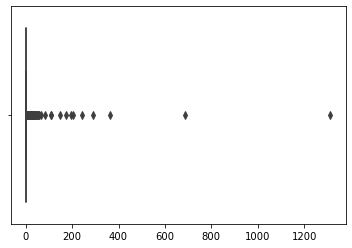

In [12]:
set_sizes = [count for scaffold, count in counter.items()]
sns.boxplot(set_sizes)

In [13]:
frac_train = 0.8
frac_valid = 0.1

train_cutoff = int(frac_train * len(correct_smiles))
valid_cutoff = int((frac_train + frac_valid) * len(correct_smiles))
train_inds: List[int] = []
valid_inds: List[int] = []
test_inds: List[int] = []

In [14]:
train_cutoff

11997

In [15]:
valid_cutoff

13497

In [16]:
unique_scaffolds = list(counter.keys())

In [17]:
for i in range(5) :
    
    random.shuffle(unique_scaffolds)
    
    train_inds: List[int] = []
    valid_inds: List[int] = []
    test_inds: List[int] = []
    
    for scaffold in unique_scaffolds:
        indices = [i for i, s in enumerate(all_generic_scaffolds) if s == scaffold]
        if len(train_inds) + len(indices) > train_cutoff:
            if len(train_inds) + len(valid_inds) + len(indices) > valid_cutoff:
                test_inds += indices
            else:
                valid_inds += indices
        else:
            train_inds += indices
            
    train_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in train_inds]
    valid_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in valid_inds]
    test_smiles = [smiles for i, smiles in enumerate(correct_smiles) if i in test_inds]
    
    with open(f'data/train_smiles_scaffold_split_{i}.txt', 'w') as f :
        for smiles in train_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(f'data/val_smiles_scaffold_split_{i}.txt', 'w') as f :
        for smiles in valid_smiles :
            f.write(smiles)
            f.write('\n')
        
    with open(f'data/test_smiles_scaffold_split_{i}.txt', 'w') as f :
        for smiles in test_smiles :
            f.write(smiles)
            f.write('\n')

In [18]:
len(train_inds)

11997

In [19]:
len(valid_inds)

1500

In [20]:
len(test_inds)

1500